# User Segmentation을 위한 미국 인구 조사 데이터 분석

<i>reference : https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/ </i>

<I>Created by Jesam Kim (jesamkim@)
</I>

<B>select kernel : conda_mxnet_p37</B>

1. Amazon S3에서 데이터 로드
2. EDA (예비 데이터 분석) - 데이터 정리 및 탐색
   > 데이터 정리, 데이터 시각화, feature 엔지니어링
3. 데이터 모델링
   > 차원 감소, PCA 모델 특성 액세스, PCA 모델 배포, 감독되지 않은 클러스터링을 사용한 User Segmentation
4. 모델링에서 결론 도출
   > KMeans 모델 속성에 액세스

## 1단계 : Amazon S3에서 데이터 로드

In [1]:
import os
import boto3
import io
import sagemaker

%matplotlib inline

import pandas as pd
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')
import pickle, gzip, urllib, json
import csv

# get_execution_role 함수는 노트북 인스턴스를 생성할 때 IAM 역할을 검색
from sagemaker import get_execution_role
role = get_execution_role()

### 데이터 집합 Load

In [9]:
s3_clinet = boto3.client('s3')
data_bucket_name = 'aws-ml-blog-sagemaker-census-segmentation'

In [13]:
# 버킷에 포함된 객체 목록을 가져옴

obj_list = s3_clinet.list_objects(Bucket = data_bucket_name)
file = []
for contents in obj_list['Contents']:
    file.append(contents['Key'])
print(file)
['acs2015_county_data.csv', 'counties/']
file_data = file[0]



['Census_Data_for_SageMaker.csv']


In [15]:
# 버킷의 CSV 파일에서 데이터를 가져옴

response = s3_clinet.get_object(Bucket = data_bucket_name, Key = file_data)
response_body = response["Body"].read()
counties = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False) 

In [16]:
# 데이터의 첫 5행 확인

counties.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


## 2단계 : 탐색적 데이터 분석 EDA - 데이터 정리 및 탐색

### a. 데이터 정리

In [17]:
# 데이터 크기 확인 --> 37개 컬럼에 3220 행

counties.shape

(3220, 37)

분석을 쉽게 하기 위해서 <b>불완전한 데이터를 삭제</b> 합니다.


In [18]:
counties.dropna(inplace=True)

# 데이터 크기 재확인 --> 37개 컬럼에 3218 행
counties.shape

(3218, 37)

State와 County 컬럼 같이 설명 참조 열 중 일부를 결합하고 숫자 피쳐 컬럼을 남겨두겠습니다.

이제 'state-county'를 인덱스로 설정할 수 있으며, 나머지 숫자 기능은 각 고유 county 속성이 됩니다.

In [19]:
counties.index=counties['State'] + "-" + counties['County']
counties.head()
drop=["CensusId" , "State" , "County"]
counties.drop(drop, axis=1, inplace=True)
counties.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


### b. 데이터 시각화

숫자 컬럼과 범주형 컬럼이 혼합된 데이터 세트가 만들어 졌습니다. 

일부 숫자 컬럼에 대한 데이터를 시각화하고 분포가 어떤게 보이는지 확인해 봅니다.

/home/ec2-user/anaconda3/envs/mxnet_p37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


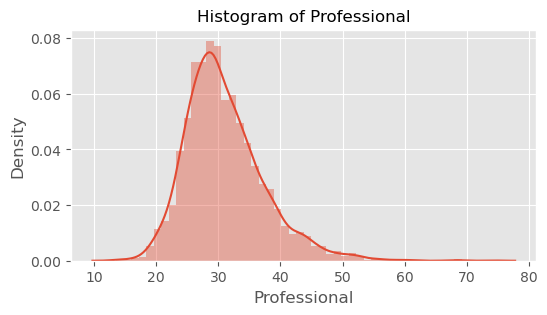

/home/ec2-user/anaconda3/envs/mxnet_p37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


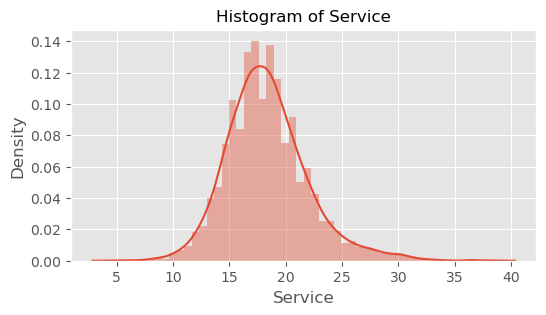

/home/ec2-user/anaconda3/envs/mxnet_p37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


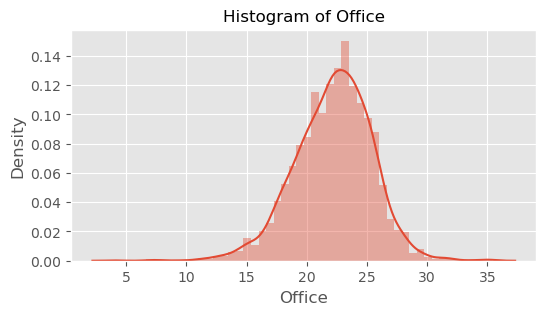

In [20]:
import seaborn as sns

for a in ['Professional', 'Service', 'Office']:
    ax=plt.subplots(figsize=(6,3))
    ax=sns.distplot(counties[a])
    title="Histogram of " + a
    ax.set_title(title, fontsize=12)
    plt.show()

예를 들어, 위의 그림에서 전문직, 서비스 또는 사무실 직종에 종사하는 근로자의 비율이있는 카운티의 분포를 관찰 할 수 있습니다. 히스토그램을 보는 것은 평균 또는 왜곡과 같은 이러한 특징의 특성을 시각적으로 나타낼 수 있습니다. 예를 들어 전문 노동자의 분포는 전형적인 카운티가 약 25-30 %의 전문 노동자를 보유하고 있으며, 오른쪽 스큐, 긴 꼬리 및 전문 노동자 %가 일부 카운티에서는 거의 80 %로 상향 조정되고 있음을 보여줍니다.

### c. Feature 엔지니어링

데이터 스케일링 – 서로 다른 피쳐 컬럼 간의 상대적 거리를 비교할 수 있도록 거리 기반 분석 방법을 사용하기 위해 숫자 열의 스케일링을 표준화해야 합니다. 

minmaxscaler를 사용하여 숫자 열을 변환하여 0과 1 사이에 놓이도록 할 수 있습니다.

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
counties_scaled=pd.DataFrame(scaler.fit_transform(counties))
counties_scaled.columns=counties.columns
counties_scaled.index=counties.index

이제 모든 숫자 컬럼의 최소값이 0이고 최대 1임을 확인할 수 있습니다.

In [22]:
counties_scaled.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.009883,0.009866,0.009899,0.110170,0.756024,0.100942,0.018682,0.029405,0.006470,0.011540,...,0.046496,0.041154,0.124428,0.470140,0.009806,0.760810,0.194426,0.216744,0.029417,0.221775
std,0.031818,0.031692,0.031948,0.192617,0.229682,0.166262,0.078748,0.062744,0.035446,0.033933,...,0.051956,0.042321,0.085301,0.143135,0.032305,0.132949,0.106923,0.106947,0.046451,0.112138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001092,0.001117,0.001069,0.019019,0.642285,0.005821,0.001086,0.004808,0.000000,0.001371,...,0.019663,0.023018,0.072581,0.373402,0.000948,0.697279,0.120861,0.147541,0.010204,0.150685
50%,0.002571,0.002591,0.002539,0.039039,0.842685,0.022119,0.003257,0.012019,0.000000,0.003219,...,0.033708,0.033248,0.104839,0.462916,0.002234,0.785714,0.172185,0.188525,0.020408,0.208219
75%,0.006594,0.006645,0.006556,0.098098,0.933868,0.111758,0.006515,0.028846,0.000000,0.008237,...,0.056180,0.048593,0.150538,0.560102,0.006144,0.853741,0.243377,0.256831,0.030612,0.271233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3단계 : 데이터 모델링

### a. 차원 감소 (Dimensionality reduction)

데이터의 차원을 줄이기 위해 PCA(주성분 분석)을 사용할 것 입니다. 이 메서드는 데이터 행렬을 서로 직교하는 피쳐로 분해합니다. 그 결과 직교 피쳐는 원래 피쳐의 선형 조합입니다.

Amazon SageMaker 용 PCA 알고리즘을 사용합니다.

먼저 PCA SageMaker 모델의 인스턴스를 가져와 호출합니다. 그런 다음 모델의 다른 매개 변수를 지정합니다. 이러한 매개 변수는 학습 중에 사용할 인스턴스 수 또는 사용할 인스턴스 유형과 같은 리소스 구성 매개 변수일 수 있습니다. 또는 PCA를 수행할 때 사용할 구성 요소 수와 같은 computation hyperparameter 모델링할 수도 있습니다.

PCA 모델에 대한 설명은 다음을 참조하세요 : http://sagemaker.readthedocs.io/en/latest/pca.html

Amazon SageMaker Python SDK에서 제공하는 도구를 사용하여 데이터를 기본 버킷에 업로드 합니다.

In [23]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

from sagemaker import PCA

num_components = 33

pca_SM = PCA(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path="s3://" + bucket + "/counties/",
    num_components=num_components,
)

다음으로, DataFrame에서 numpy 배열을 추출하고 float32로 명시적으로 캐스팅하여 Amazon SageMaker에 대한 데이터를 준비합니다.

In [24]:
train_data = counties_scaled.values.astype('float32')

Amazon SageMaker PCA 모델의 record_set 함수는 numpy 배열을 입력 데이터를 학습하는 데 필요한 형식인 레코드 집합 형식으로 변환합니다. 이는 모든 Amazon SageMaker 내장 모델에 대한 요구 사항입니다. 이 데이터 유형을 사용하면 sklearn 구현과 같은 동일한 모델의 다른 구현과 비교하여 더 큰 데이터 세트에 대해 Amazon SageMaker 내에서 모델 학습을 더 빠르게 수행할 수 있는 이유 중 하나입니다.

PCA 모델에서 fit 함수를 호출하여 학습 데이터를 전달하면 교육 인스턴스 또는 클러스터가 훈련 작업을 수행합니다.

In [25]:
%%time
pca_SM.fit(pca_SM.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-08-10 03:03:50 Starting - Starting the training job...
2022-08-10 03:04:14 Starting - Preparing the instances for trainingProfilerReport-1660100630: InProgress
.........
2022-08-10 03:05:41 Downloading - Downloading input data...
2022-08-10 03:06:14 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/10/2022 03:06:58 INFO 140115020646208] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[08/10/2022 03:06:58 INFO 140115020646208] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': '34', 'mini_batch_size': '500', 'num_components': '33'}
[08/10/2022 03:06:58 INFO 1401150

### b. PCA 모델 attributes 액세스

모델을 만든 후 기본 모델 매개 변수에 액세스할 수 있습니다.

이제 훈련이 완료되었으므로 Amazon SageMaker 콘솔의 Training 하위 섹션에 있는 Training jobs에서 작업을 찾을 수 있습니다. 다음 코드에서 해당 작업 이름을 사용하여 검사할 모델을 지정 합니다.

모델 아티팩트는 학숩된 후 Amazon S3에 저장됩니다. 이는 Amazon SageMaker를 사용하여 학습된 모델을 배초하는 데 사용되는 것과 동일한 모델 아티팩트 입니다.

많은 Amazon SageMaker 알고리즘이 계산에 MXNet을 사용하기 때문에 모델 아티팩트는 ND 어레이로 저장 됩니다. 훈련 호출 중에 지정된 출력 경로의 경우, 모델은 GNU zip(gzip)으로 압축된 TAR 아카이브 파일인 “training job name”–> output–>model.tar.gz 입니다.

In [26]:
job_name = pca_SM.latest_training_job.name
model_key = "counties/" + job_name + "/output/model.tar.gz"

boto3.resource("s3").Bucket(bucket).download_file(model_key, "model.tar.gz")
os.system("tar -zxvf model.tar.gz")

0

모델의 압축을 풀고 나면 MXNet을 사용하여 ND 어레이를 로드할 수 있습니다.

In [27]:
import mxnet as mx
pca_model_params = mx.ndarray.load('model_algo-1')

세 그룹의 모델 매개변수가 PCA 모델 내에 포함 됩니다.

<b>mean</b> : 선택 사항이며, 원래 PCA SageMaker 함수에서 학습 단계를 호출할 때 "subset_mean" 하이퍼파라미터가 참인 경우에만 사용할 수 있습니다.

<b>v</b> : 주성분을 포함합니다. (sklearn PCA 모델의 'components_'와 동일)

<b>s</b> : PCA 변환에 대한 구성 요소의 단수 값 입니다. 이렇게 해도 원래 피쳐 공간의 % 분산이 정확히 제공되지는 않지만 투영된 피쳐 공간에서 % 분산을 제공할 수 있습니다.

explained-variance-ratio ~= square(s) / sum(square(s))

필요한 경우 정확한 분산 비율 벡터를 계산하려면 원래 데이터의 제곱합(N이라고 함)을 저장하고 분산 비율 = 제곱/N 을 계산하면 됩니다.

In [28]:
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

이 예제에서는 상위 5개 구성 요소를 살펴 봅니다.

가장 큰 5가지 구성 요소가 데이터 세트의 총 분산의 ~72%를 설명한다는 것을 알 수 있습니다.

In [29]:
s.iloc[28:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()

0    0.717983
dtype: float32

상위 5개의 구성 요소를 유지하기로 결정한 후에는 원래 s 및 v 매트릭스에서 5개의 가장 큰 구성 요소만 사용할 수 있습니다.

In [30]:
s_5=s.iloc[28:,:]
v_5=v.iloc[:,28:]
v_5.columns=[0,1,2,3,4]

이제 구성 요소에 포함 된 원래 기능의 가중치를 기반으로 각 PCA 구성 요소의 구성을 검사 할 수 있습니다. 예를 들어 다음 코드에서는 첫 번째 구성 요소를 보여 줍니다. 이 구성 요소가 높은 빈곤과 실업, 일인당 소득과 소득이 낮고 히스패닉 / 흑인 인구가 많고 백인 인구가 적은 카운티의 특성을 묘사한다는 것을 알 수 있습니다.

이것은 v_5[4] 또는 v_5의 구성 요소 목록의 마지막 구성 요소이지만 구성 요소가 가장 작은 구성 요소에서 가장 큰 구성 요소로 정렬되기 때문에 실제로 가장 큰 구성 요소입니다. 따라서 v_5[0] 은 가장 작은 구성 요소입니다. 마찬가지로, component_num의 값을 변경하여 각 구성 요소의 구성을 순환시킵니다.

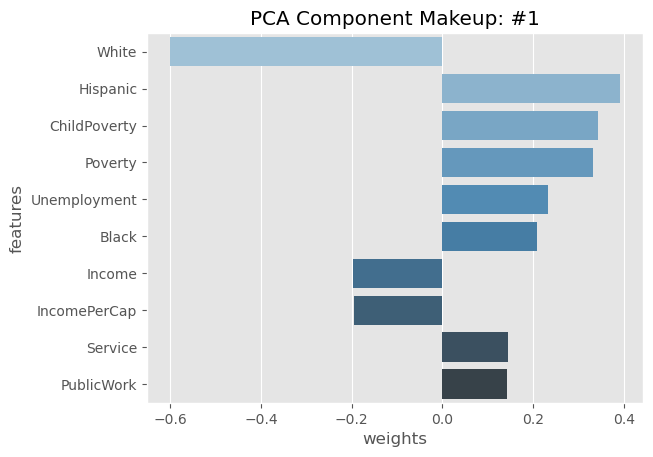

In [31]:
component_num=1

first_comp = v_5[5-component_num]
comps = pd.DataFrame(list(zip(first_comp, counties_scaled.columns)), columns=['weights', 'features'])
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
ax=sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

마찬가지로 각 PCA 구성 요소의 구성을 살펴보고 각 구성 요소에 대한 주요 positive 및 negative 특성이 무엇인지 이해할 수 있습니다.

다음 코드는 구성 요소의 이름을 지정합니다. 각 구성 요소의 고유한 구성에 대해 인사이트를 얻기 위해 자유롭게 변경할 수 있습니다.

In [32]:
PCA_list=['comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5']

#PCA_list=["Poverty/Unemployment", "Self Employment/Public Workers", "High Income/Professional & Office Workers", \
#         "Black/Native Am Populations & Public/Professional Workers", "Construction & Commuters"]

### c. PCA 모델 배포

이 모델의 Endpoint를 배포하고 이를 사용하여 예측을 수행할 수 있습니다.

이 모델은 이제 라이브로 제공되며 지정한 instance_type에서 호스팅 됩니다.

In [33]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


--------------!CPU times: user 214 ms, sys: 24.3 ms, total: 239 ms
Wall time: 7min 2s


또한 원래 데이터 세트를 모델에 전달하여 만든 모델을 사용하여 데이터를 변환할 수 있습니다. 그런 다음 가장 큰 5 개의 구성 요소를 사용할 수 있으며 이로 인해 데이터의 차원이 34에서 5로 줄어 듭니다.

In [34]:
%%time
result = pca_predictor.predict(train_data)
counties_transformed=pd.DataFrame()
for a in result:
    b=a.label['projection'].float32_tensor.values
    counties_transformed=counties_transformed.append([list(b)])
counties_transformed.index=counties_scaled.index
counties_transformed=counties_transformed.iloc[:,28:]
counties_transformed.columns=PCA_list

CPU times: user 7.51 s, sys: 0 ns, total: 7.51 s
Wall time: 7.84 s


이제 각 카운티가 이전에 분석 한 5 가지 원칙 구성 요소로 설명되는 데이터 세트를 만들었습니다. 

이 5 가지 구성 요소 각각은 원래 피쳐 공간의 선형 조합입니다. 

이전에 표시된 구성 요소의 구성을 분석하여이 5 가지 구성 요소 각각을 해석 할 수 있습니다.

In [35]:
counties_transformed.head()

,comp_1,comp_2,comp_3,comp_4,comp_5
Alabama-Autauga,-0.010824,0.120480,-0.088356,0.160527,-0.060274
Alabama-Baldwin,-0.068677,-0.023092,-0.145743,0.185969,-0.149684
Alabama-Barbour,0.093111,0.297829,0.146258,0.296662,0.506202
Alabama-Bibb,0.283526,0.011757,0.224402,0.190861,0.069224
Alabama-Blount,0.100738,-0.193824,0.022714,0.254403,-0.091030


### d. Unsupervised 클러스터링을 통한 User Segmentation

이제 Kmeans 알고리즘을 사용하여 카운티 인구를 위에서 만든 5 PCA 속성으로 나눕니다. 

Kmeans는 속성에 따라 유사한 카운티의 클러스터를 식별하는 클러스터링 알고리즘입니다. 

원래 데이터 세트에 ~ 3000 개의 카운티와 34 개의 속성이 있기 때문에 큰 기능 공간으로 인해 카운티를 효과적으로 클러스터링하기가 어려웠을 수 있습니다. 대신 기능 공간을 5개의 PCA 구성 요소로 줄였으며 이 변환된 데이터 세트에 클러스터링할 것입니다.

In [36]:
train_data = counties_transformed.values.astype('float32')

첫째, PCA 모델로 수행 한 것처럼 KMeans 모델의 하이퍼 매개 변수를 호출하고 정의합니다. 
Kmeans 알고리즘을 사용하면 사용자가 식별할 클러스터 수를 지정할 수 있습니다. 이 경우 데이터 세트에서 상위 7개 클러스터를 찾아보겠습니다.

In [37]:
from sagemaker import KMeans

num_clusters = 7
kmeans = KMeans(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path="s3://" + bucket + "/counties/",
    k=num_clusters,
)

그런 다음 학습 데이터에 대해 모델을 학습합니다.

In [38]:
%%time
kmeans.fit(kmeans.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-08-10 03:39:34 Starting - Starting the training job...ProfilerReport-1660102774: InProgress
...
2022-08-10 03:40:33 Starting - Preparing the instances for training.........
2022-08-10 03:41:54 Downloading - Downloading input data...
2022-08-10 03:42:34 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/10/2022 03:42:40 INFO 140678534698816] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '_log_level': 'info', '_num_gpus': 'auto', '_num_kv

이제 모델을 배포하고 원래 학습 집합을 전달하여 각 항목의 레이블을 가져올 수 있습니다. 이렇게하면 각 카운티가 속한 클러스터가 제공됩니다.

In [40]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

result=kmeans_predictor.predict(train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


--------!CPU times: user 336 ms, sys: 17.8 ms, total: 353 ms
Wall time: 4min 2s


클러스터 수의 분석과 클러스터의 분포를 확인해 봅니다.

In [41]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_labels)[0].value_counts()

4.0    910
0.0    759
3.0    497
2.0    437
6.0    325
5.0    190
1.0    100
Name: 0, dtype: int64

/home/ec2-user/anaconda3/envs/mxnet_p37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


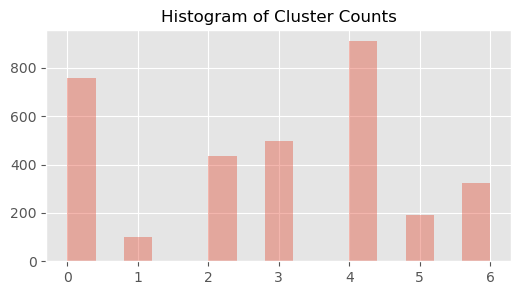

In [42]:
ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

그러나 설명 가능성을 높이려면 클러스터 센터를 가져오기 위해 기본 모델에 액세스해야 합니다. 이 센터는 각 클러스터를 특징 짓는 기능을 설명하는 데 도움이됩니다.

# 4단계 : 모델링에서 결론 도출

모델링 결과를 설명하는 것은 분석을 활용하는 데 중요한 단계 입니다.

PCA와 KMeans, 그리고 Amazon SageMaker에서 학습된 모델 내의 모델 속성에 포함된 정보를 결합하여 데이터를 기반으로 구체적인 결론을 도출할 수 있습니다.

## a. KMeans 모델 속성에 액세스

In [43]:
# KMeans 모델이 저장된 버킷으로 이동하여 추출합니다.

job_name = kmeans.latest_training_job.name
model_key = "counties/" + job_name + "/output/model.tar.gz"

boto3.resource("s3").Bucket(bucket).download_file(model_key, "model.tar.gz")
os.system("tar -zxvf model.tar.gz")
Kmeans_model_params = mx.ndarray.load("model_algo-1")

KMeans 모델에 포함된 1개의 모델 매개변수 세트가 있습니다.

Cluster Centroid Locations: KMeans 알고리즘으로 식별되는 각 클러스터의 중심 위치 입니다.

클러스터 위치는 변환된 PCA 데이터를 모델에 전달했기 때문에 5개의 구성 요소가 있는 PCA 변환 공간에 제공됩니다.

In [44]:
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=counties_transformed.columns
cluster_centroids

,comp_1,comp_2,comp_3,comp_4,comp_5
0,-0.043530,-0.053409,-0.058860,0.056648,-0.232412
1,-0.089946,-0.395695,-0.190531,-0.258825,1.225143
2,0.074711,0.219130,0.099540,0.173169,0.354615
3,0.010647,0.078214,0.085763,-0.332010,-0.162639
4,-0.023323,-0.078156,0.131917,0.121215,-0.069331
5,0.199120,-0.236533,-0.119520,-0.176573,0.339902
6,-0.023339,0.104614,-0.394810,0.041037,-0.070059


변환된 피쳐 공간에서 중심과 그 위치의 히트맵을 그릴 수 있습니다. 이를 통해 각 클러스터를 정의하는 특성에 대한 통찰력을 얻을 수 있습니다. 종종 감독되지 않은 학습으로 인해 결과를 해석하기가 어렵습니다. 이것은 PCA 플러스 클러스터링 기술의 결과를 함께 활용하는 한 가지 방법입니다. 우리는 각 PCA 구성 요소의 구성을 검사 할 수 있었기 때문에 이전에 통합 한 PCA 구성 요소의 관점에서 각 중심이 무엇을 나타내는지 이해할 수 있습니다.

예를 들어, 클러스터 1은 "건설 및 통근자" 속성에서 가장 높은 값을 가지며 다른 클러스터와 비교하여 "자영업/공공 근로자" 특성에서 가장 낮은 값을 갖는 것을 볼 수 있습니다. 마찬가지로 클러스터 4는 "건설 및 통근자", "고소득 / 전문 및 사무직 근로자"및 "자영업 / 공공 근로자"에서 높은 가치를 지닙니다.

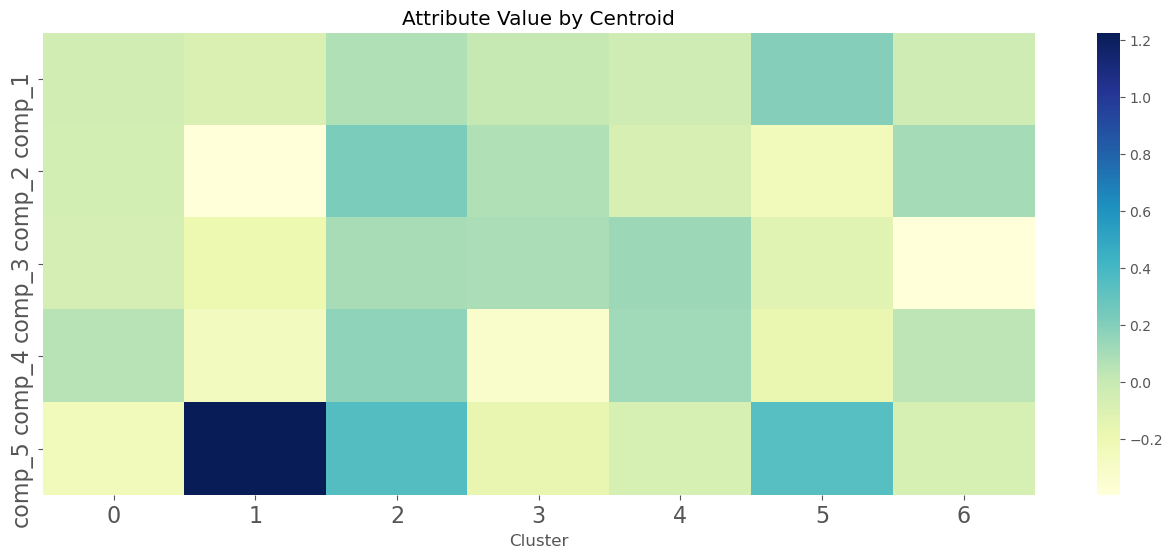

In [45]:
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

또한 클러스터 레이블을 각 개별 카운티에 다시 매핑하고 자연스럽게 그룹화 된 카운티를 조사할 수 있습니다.

comp_1 : Poverty/Unemployment

comp_2 : Self Employment/Public Workers

comp_3 : High Income/Professional & Office Workers

comp_4 : Black/Native Am Populations & Public/Professional Workers

comp_5 : Construction & Commuters

In [46]:
counties_transformed['labels']=list(map(int, cluster_labels))
counties_transformed.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,labels
Alabama-Autauga,-0.010824,0.120480,-0.088356,0.160527,-0.060274,0
Alabama-Baldwin,-0.068677,-0.023092,-0.145743,0.185969,-0.149684,0
Alabama-Barbour,0.093111,0.297829,0.146258,0.296662,0.506202,2
Alabama-Bibb,0.283526,0.011757,0.224402,0.190861,0.069224,4
Alabama-Blount,0.100738,-0.193824,0.022714,0.254403,-0.091030,4


이제 클러스터 1과 같이 클러스터 중 하나를 더 자세히 살펴볼 수 있습니다. 중심형의 위치를 자세히 살펴보면 "건설 및 통근자"(comp_5)속성에 대해 가장 높은 값을 가지고 있음을 알 수 있습니다. 이제 어떤 카운티가 해당 설명에 적합한지 확인할 수 있습니다.

In [47]:
cluster=counties_transformed[counties_transformed['labels']==1]
cluster.head(5)

,comp_1,comp_2,comp_3,comp_4,comp_5,labels
Arizona-Santa Cruz,-0.014149,-0.347113,-0.386305,-0.284937,0.753071,1
California-Imperial,-0.015831,-0.291125,-0.296619,-0.279273,0.885126,1
New Mexico-Mora,0.062434,-0.124934,-0.162434,-0.637112,0.829913,1
New Mexico-Rio Arriba,-0.072426,-0.075995,-0.274184,-0.471792,0.827892,1
New Mexico-San Miguel,-0.143846,-0.146673,-0.221657,-0.467999,0.846824,1


# 결론

방금 감독되지 않은 학습을위한 데이터 과학 워크플로우를 진행했으며, 특히 PCA를 사용하여 차원을 줄인 후 KMean을 사용하여 데이터 세트를 클러스터링했습니다. 

Amazon SageMaker에서 생성된 기본 모델에 액세스함으로써 모델링의 설명 가능성을 개선하고 실행 가능한 결론을 도출할 수 있었습니다. 

이러한 기술을 사용하여 우리는 미국의 여러 카운티의 본질적인 특성을 더 잘 이해하고 유권자를 그에 따라 그룹으로 나눌 수있었습니다.

<b><i>엔드포인트는 영구적이므로 AWS 청구서에 초과 요금이 부과되지 않도록 완료되었으므로 이제 엔드포인트를 삭제해 보겠습니다.

In [48]:
pca_predictor.delete_endpoint()
kmeans_predictor.delete_endpoint()